In [8]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *

In [9]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [10]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]

ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]

# pp_summary = '../'+expand(config['data']['p_pred']['summary'], species='human')[0]

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'polya'
obs_col = 'sample'
go_gene_subset = 'protein_coding'
predom_iso_subset = 'protein_coding'

m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]

In [11]:
# https://academic.oup.com/bib/article/18/2/205/2562739

In [12]:
def compute_tau(df):
    """
    Compute tissue-specificity index for an abundance matrix output
    from `get_tpm_table`.
    """
    # number of samples 
    n = len(df.columns)
    print(f'Found {n} samples')
    
    # log-transform data and add 1 pseudocount to data
    df = np.log2(df+1)
    # df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # get max of TPM for transcript across tissues
    temp = df.max(axis=1)
    temp_ind = temp.index.tolist()

    df = df.transpose()
    df_ind = df.columns.tolist()
    assert df_ind==temp_ind

    # compute x-hat (TPM / max TPM across tissues)
    x_hat = df/temp
    
    # compute (1-x-hat) 
    x_hat = 1-x_hat

    # compute sum across tissues
    x_hat = x_hat.transpose()
    x_hat['sum'] = x_hat.sum(axis=1)
    
    # compute tau for each transcript
    x_hat['tau'] = x_hat['sum']/n
    tau_df = x_hat[['tau']]
    
    return tau_df

In [13]:
meta = pd.read_csv(lib_meta, sep='\t')
meta.loc[meta.tissue_or_cell_line == 'tissue', 'general_tissue_cell_type'].unique()

array(['adrenal gland', 'vessels', 'cortex', 'heart', 'kidney', 'colon',
       'lung', 'adipose', 'ovary', 'muscle', 'liver'], dtype=object)

In [14]:
meta = pd.read_csv(lib_meta, sep='\t')
samples = meta.loc[meta.tissue_or_cell_line == 'tissue', 'general_tissue_cell_type'].unique().tolist()
# samples = meta.loc[meta.tissue_or_cell_line == 'tissue', 'sample'].unique().tolist()

tau_df = pd.DataFrame()
for feat in ['iso', 'tss', 'ic', 'tes']:
    df = pd.read_csv(filt_ab, sep='\t')
    df, tids = get_tpm_table(df,
                       how=feat,
                       min_tpm=min_tpm,
                       gene_subset='protein_coding',
                       groupby='general_tissue_cell_type',
                       samples=samples)
    df = df[samples]
    temp = compute_tau(df) 
    print(temp.head())
    temp['feat'] = feat
    temp['temp'] = temp.index.tolist()
    if feat == 'iso':
        temp['gid'] = temp.temp.str.split('[', expand=True)[0]
    else:
        temp['gid'] = temp.temp.str.split('_', expand=True)[0]
    temp.drop('temp', axis=1, inplace=True)
    tau_df = pd.concat([tau_df, temp], axis=0)
tau_df.reset_index(inplace=True)

Calculating iso TPM values
Subsetting for protein_coding genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 236615
# isos >= 1 tpm: 213476
Applying gene type and novelty subset
Averaging over general_tissue_cell_type
Number of isos reported: 191325
Found 11 samples
general_tissue_cell_type       tau
ENSG00000000003[1,1,1]    0.703886
ENSG00000000003[1,1,5]    0.445206
ENSG00000000003[1,1,6]    0.701237
ENSG00000000003[1,1,7]    0.346632
ENSG00000000003[1,1,8]    0.434952
Calculating tss TPM values
Subsetting for protein_coding genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # tsss detected: 73812
# tsss >= 1 tpm: 64913
Applying gene type and novelty subset
Averaging over general_tissue_cell_type
Number of tsss reported: 50292
Found 11 samples
general_tissue_cell_type       tau
ENSG00000000003_1         0.321574
ENSG00000000005_3         0.842936
ENSG00000000419_1         0.191810
ENSG00000000419_8         0.813744
ENSG00000000457_1         0.339817
Calculating ic TPM values
Subsetting for protein_coding genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # ics detected: 145392
# ics >= 1 tpm: 131409
Applying gene type and novelty subset
Averaging over general_tissue_cell_type
Number of ics reported: 113956
Found 11 samples
general_tissue_cell_type       tau
ENSG00000000003_1         0.332042
ENSG00000000003_10        0.758590
ENSG00000000003_11        0.853510
ENSG00000000003_12        0.832334
ENSG00000000003_4         0.909091
Calculating tes TPM values
Subsetting for protein_coding genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # tess detected: 87189
# tess >= 1 tpm: 76035
Applying gene type and novelty subset
Averaging over general_tissue_cell_type
Number of tess reported: 59903
Found 11 samples
general_tissue_cell_type       tau
ENSG00000000003_1         0.652372
ENSG00000000003_3         0.909091
ENSG00000000003_5         0.436653
ENSG00000000003_6         0.583603
ENSG00000000003_7         0.340480


In [15]:
feat_tau_df = tau_df.copy(deep=True)

In [18]:
# # also compute on the gene level
# meta = pd.read_csv(lib_meta, sep='\t')
# samples = meta.loc[meta.tissue_or_cell_line == 'tissue', 'general_tissue_cell_type'].unique().tolist()
# # samples = meta.loc[meta.tissue_or_cell_line == 'tissue', 'sample'].unique().tolist()

# tau_df = pd.DataFrame()
# df = pd.read_csv(filt_ab, sep='\t')
# df, inds = get_tpm_table(df,
#                     how='gene',
#                     min_tpm=min_tpm,
#                     gene_subset='protein_coding',
#                     groupby='general_tissue_cell_type',
#                     samples=samples)
# df = df[samples]
# temp = compute_tau(df) 
temp['gid'] = temp.index.tolist()
temp.reset_index(drop=True, inplace=True)
temp['feat'] = 'gene'

In [22]:
temp['feat'] = 'gene'
temp.head()

general_tissue_cell_type,tau,gid,feat
0,0.321574,ENSG00000000003,gene
1,0.886769,ENSG00000000005,gene
2,0.189697,ENSG00000000419,gene
3,0.339817,ENSG00000000457,gene
4,0.618639,ENSG00000000460,gene


In [21]:
feat_tau_df.head()

general_tissue_cell_type,index,tau,feat,gid
0,"ENSG00000000003[1,1,1]",0.703886,iso,ENSG00000000003
1,"ENSG00000000003[1,1,5]",0.445206,iso,ENSG00000000003
2,"ENSG00000000003[1,1,6]",0.701237,iso,ENSG00000000003
3,"ENSG00000000003[1,1,7]",0.346632,iso,ENSG00000000003
4,"ENSG00000000003[1,1,8]",0.434952,iso,ENSG00000000003


In [24]:
spec_cutoff=0.75

In [25]:
tau_df = pd.concat([feat_tau_df, temp], axis=0)

{'tss': '#56B4E9', 'ic': '#CC79A7', 'tes': '#E69F00', 'iso': '#009E73', 'gene': '#002f22'}


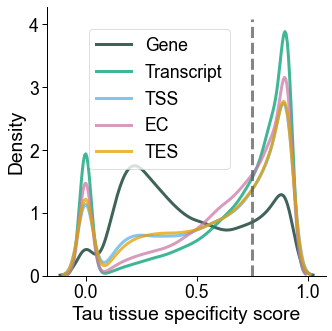

In [27]:
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

c_dict, order = get_feat_triplet_colors_2()
c_dict['gene'] = '#002f22'
order = ['gene']+order
# c_dict['iso'] = c_dict.pop('triplet')
print(c_dict)

ax = sns.displot(data=tau_df, x='tau', kind='kde',
                 hue='feat', common_norm=False, palette=c_dict,
                 hue_order=order[::-1],
                 legend=False, linewidth=3, alpha=0.75)
ax.set(xlabel='Tau tissue specificity score')
ylims = plt.gca().get_ylim()
color = '#5c5c5c'
plt.gca().vlines(spec_cutoff, ylims[0], ylims[1],
                      colors=color, linestyles='dashed',
                      linewidth=3, alpha=0.75)

fig = plt.gcf()
fig.legend(['Gene', 'Transcript', 'TSS','EC', 'TES'], bbox_to_anchor=(0.7, 0.9))


plt.savefig('figures/tau_dists_protein_coding_tissues.pdf', bbox_inches='tight', dpi=500)

{'tss': '#56B4E9', 'ic': '#CC79A7', 'tes': '#E69F00', 'iso': '#009E73', 'gene': '#002f22'}


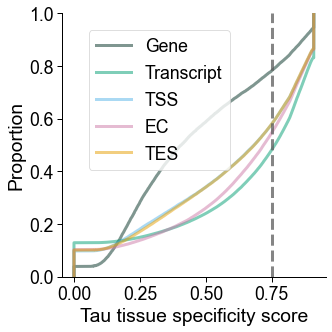

In [28]:
# ecdf version of the plot
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

c_dict, order = get_feat_triplet_colors_2()
c_dict['gene'] = '#002f22'
order = ['gene']+order
# c_dict['iso'] = c_dict.pop('triplet')
print(c_dict)

ax = sns.displot(data=tau_df, x='tau', kind='ecdf',
                 hue='feat', palette=c_dict,
                 hue_order=order[::-1],
                 legend=False, linewidth=3, alpha=0.5)
ax.set(xlabel='Tau tissue specificity score')
ylims = plt.gca().get_ylim()
color = '#5c5c5c'
plt.gca().vlines(spec_cutoff, ylims[0], ylims[1],
                      colors=color, linestyles='dashed',
                      linewidth=3, alpha=0.75)


fig = plt.gcf()
fig.legend(['Gene', 'Transcript', 'TSS','EC', 'TES'], bbox_to_anchor=(0.7, 0.9))


plt.savefig('figures/tau_ecdf_protein_coding_tissues.pdf', bbox_inches='tight', dpi=500)

90.63% of protein coding genes have >= 1 iso w/ tau >= 0.75
65.18% of protein coding genes have >= 1 tss w/ tau >= 0.75
83.93% of protein coding genes have >= 1 ic w/ tau >= 0.75
71.24% of protein coding genes have >= 1 tes w/ tau >= 0.75
21.79% of protein coding genes have >= 1 gene w/ tau >= 0.75


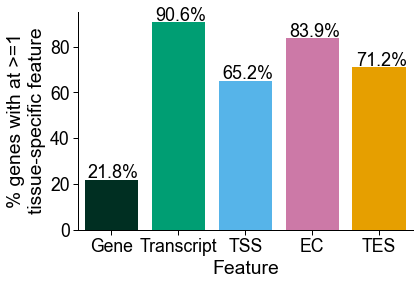

In [39]:
# what % of genes have tissue-specific usage of each feat?
feats = ['iso', 'tss', 'ic', 'tes', 'gene']
df = pd.DataFrame()
percs = []
for f in feats:
    temp = tau_df.loc[tau_df.feat==f].copy(deep=True)
    temp = temp[['gid', 'tau']]
    temp['tissue_specific'] = temp['tau'] >= spec_cutoff
    temp = temp[['gid', 'tissue_specific']]
    temp['n_tot_genes'] = len(temp.gid.unique().tolist())
    temp = temp.groupby(['tissue_specific', 'n_tot_genes']).nunique().reset_index()
    temp.rename({'gid':'n_genes'}, axis=1, inplace=True)
    temp['perc'] = (temp['n_genes']/temp['n_tot_genes'])*100
    thing = temp.loc[temp.tissue_specific==True]['perc'].values[0]
    print(f'{thing:.2f}% of protein coding genes have >= 1 {f} w/ tau >= {spec_cutoff}')
    percs.append(thing)
df['perc'] = percs
df['feat'] = feats

ax = sns.barplot(data=df, y='perc',
                 x='feat', palette=c_dict, 
                 saturation=1, order=order)

def add_perc_2(ax):
    ylim = ax.get_ylim()[1]
    n_cats = len(ax.patches)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
#         x = p.get_x() + p.get_width() / 2 - 0.45
        x = p.get_x() + p.get_width() / 2 - (0.07)*n_cats
        y = p.get_y() + p.get_height() + ylim*0.00625
        ax.annotate(percentage, (x, y), size = 18)

add_perc_2(ax)

ylabel = '% genes with at >=1\ntissue-specific feature'
xlabel = 'Feature'
_ = ax.set(xlabel=xlabel, ylabel=ylabel)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ['Gene', 'Transcript', 'TSS', 'EC', 'TES']
ax.set_xticklabels(labels)

fname = 'figures/perc_genes_w_one_tissue_spec_feat.pdf'
plt.savefig(fname, dpi=700)

In [31]:
df.head()

,perc,feat
0,90.626972,iso
1,65.177496,tss
2,83.927035,ic
3,71.236020,tes


Original labels: ['iso', 'tss', 'ic', 'tes']


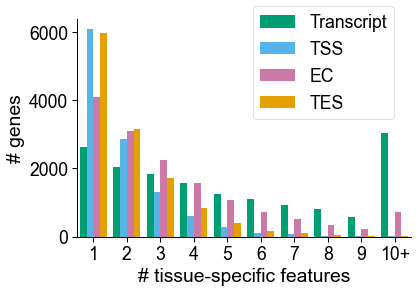

In [125]:
# how many tissue specific features does each gene have?
temp = tau_df.copy(deep=True)
temp['tissue_specific'] = temp['tau'] >= spec_cutoff
temp.drop(['tau'], axis=1, inplace=True)

temp.columns.name = ''
temp = temp.groupby(['feat', 'gid', 'tissue_specific']).nunique().reset_index().rename({'index':'n_feats'}, axis=1)
temp.loc[temp.n_feats>=10, 'n_feats'] = 10
temp = temp.loc[temp.tissue_specific==True]
temp.head()
ax = sns.countplot(temp, x='n_feats', hue='feat',
                   palette=c_dict,
                   hue_order=order,
                   saturation=1)
ylabel = '# genes'
xlabel = '# tissue-specific features'
ax.set(xlabel=xlabel,
       ylabel=ylabel)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[-1] = '10+'

_ = ax.set_xticklabels(labels)

handles, labels = ax.get_legend_handles_labels()
print("Original labels:", labels)
new_labels = ['Transcript', 'TSS', 'EC', 'TES']
ax.legend(handles, new_labels, title='', bbox_to_anchor=(0.5, 0.5))

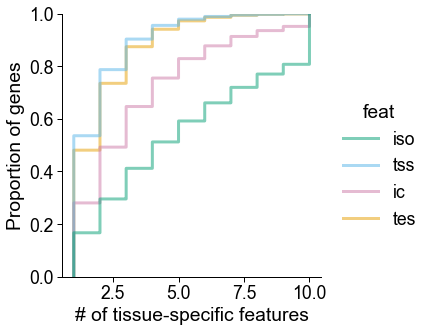

In [128]:
ax = sns.displot(data=temp, x='n_feats', kind='ecdf',
                 hue='feat', palette=c_dict,
                 hue_order=order, linewidth=3, alpha=0.5)
xlabel = '# of tissue-specific features'
ylabel = 'Proportion of genes'
ax.set(xlabel=xlabel, ylabel=ylabel)

In [28]:
tau_df = pd.DataFrame()
for feat in ['iso', 'tss', 'ic', 'tes']:
    df = pd.read_csv(filt_ab, sep='\t')
    df, tids = get_tpm_table(df,
                       how=feat,
                       min_tpm=min_tpm,
                       gene_subset=gene_subset,
                       groupby='sample')
    temp = compute_tau(df) 
    print(temp.head())
    temp['feat'] = feat
    tau_df = pd.concat([tau_df, temp], axis=0)
    

Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 236615
# isos >= 1 tpm: 213476
Applying gene type and novelty subset
Averaging over biosample
Found 51 total samples
Number of isos reported: 209819
Found 51 samples
biosample                    tau
ENSG00000000003[1,1,1]  0.789429
ENSG00000000003[1,1,5]  0.593311
ENSG00000000003[1,1,6]  0.801993
ENSG00000000003[1,1,7]  0.546595
ENSG00000000003[1,1,8]  0.503875
Calculating tss TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # tsss detected: 73812
# tsss >= 1 tpm: 64913
Applying gene type and novelty subset
Averaging over biosample
Found 51 total samples
Number of tsss reported: 61664
Found 51 samples
biosample               tau
ENSG00000000003_1  0.490305
ENSG00000000005_3  0.971963
ENSG00000000419_1  0.276564
ENSG00000000419_8  0.852418
ENSG00000000457_1  0.487450
Calculating ic TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # ics detected: 145392
# ics >= 1 tpm: 131409
Applying gene type and novelty subset
Averaging over biosample
Found 51 total samples
Number of ics reported: 128159
Found 51 samples
biosample                tau
ENSG00000000003_1   0.495843
ENSG00000000003_10  0.741649
ENSG00000000003_11  0.854999
ENSG00000000003_12  0.857591
ENSG00000000003_4   0.980392
Calculating tes TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # tess detected: 87189
# tess >= 1 tpm: 76035
Applying gene type and novelty subset
Averaging over biosample
Found 51 total samples
Number of tess reported: 72806
Found 51 samples
biosample               tau
ENSG00000000003_1  0.748463
ENSG00000000003_3  0.980392
ENSG00000000003_5  0.587896
ENSG00000000003_6  0.746722
ENSG00000000003_7  0.540710


In [33]:
c_dict, order = get_feat_triplet_colors()
c_dict['iso'] = c_dict.pop('triplet')
c_dict

{'tss': '#56B4E9', 'ic': '#CC79A7', 'tes': '#E69F00', 'iso': '#009E73'}

In [34]:
spec_cutoff=0.85

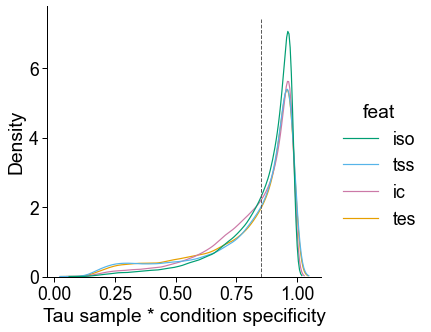

In [35]:
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
ax = sns.displot(data=tau_df, x='tau', kind='kde', hue='feat', common_norm=False, palette=c_dict)
ax.set(xlabel='Tau sample * condition specificity')
ylims = plt.gca().get_ylim()
color = '#5c5c5c'
plt.gca().vlines(spec_cutoff, ylims[0], ylims[1],
                      colors=color, linestyles='dashed',
                      linewidth=1)
plt.savefig('figures/tau_dists.pdf', bbox_inches='tight', dpi=500)

In [273]:
tau_df.reset_index(inplace=True)


In [274]:
tau_df

biosample,index,tau,feat,specific
0,"ENSG00000000003[1,1,1]",0.789429,iso,False
1,"ENSG00000000003[1,1,5]",0.593311,iso,False
2,"ENSG00000000003[1,1,6]",0.801993,iso,False
3,"ENSG00000000003[1,1,7]",0.546595,iso,False
4,"ENSG00000000003[1,1,8]",0.503875,iso,False
...,...,...,...,...
472443,ENSG00000285976_1,0.281481,tes,False
472444,ENSG00000285976_2,0.343918,tes,False
472445,ENSG00000285976_3,0.832833,tes,False
472446,ENSG00000285976_4,0.581714,tes,False


In [285]:
tau_df['specific'] = tau_df.tau>=spec_cutoff
temp = tau_df[['index', 'feat', 'specific']].groupby(['feat', 'specific']).count().rename({'index':'n_spec_feat'}, axis=1).reset_index()
temp2 = tau_df[['index', 'feat']].groupby('feat').count().rename({'index':'n_total_feat'}, axis=1).reset_index()

In [290]:
temp = temp.merge(temp2, how='left', on=['feat'])
temp

biosample,feat,specific,n_spec_feat,n_total_feat
0,ic,False,57653,128159
1,ic,True,70506,128159
2,iso,False,77433,209819
3,iso,True,132386,209819
4,tes,False,31954,72806
5,tes,True,40852,72806
6,tss,False,26327,61664
7,tss,True,35337,61664


In [292]:
temp['perc'] = (temp.n_spec_feat/temp.n_total_feat)*100
temp

biosample,feat,specific,n_spec_feat,n_total_feat,perc
0,ic,False,57653,128159,44.985526
1,ic,True,70506,128159,55.014474
2,iso,False,77433,209819,36.904665
3,iso,True,132386,209819,63.095335
4,tes,False,31954,72806,43.889240
5,tes,True,40852,72806,56.110760
6,tss,False,26327,61664,42.694279
7,tss,True,35337,61664,57.305721


In [226]:
# get tissue-specific bois
df = tau_df.loc[(tau_df.tau>=spec_cutoff)&(tau_df.feat=='iso')]
df.head()

biosample,tau,feat
"ENSG00000000003[1,10,1]",0.862173,iso
"ENSG00000000003[1,10,5]",0.854099,iso
"ENSG00000000003[1,10,6]",0.967408,iso
"ENSG00000000003[1,10,8]",0.872658,iso
"ENSG00000000003[1,11,5]",0.961213,iso


In [227]:
# what does diversity look like between these guys? 
ca = cerberus.read(cerberus_h5)
gtf_df,_,_ = get_gtf_info(ver='v40_cerberus', add_stable_gid=True)
tids = df.index.tolist() 
df = ca.get_subset_triplets(tids, source='specific_isos')
df.rename({'gene_id':'gid'}, axis=1, inplace=True)
df = df.merge(gtf_df[['gid_stable', 'gname', 'biotype_category']], how='left', left_on='gid', right_on='gid_stable')
ca.add_triplets(df)

In [228]:
df.head()

,gid,n_iso,n_tss,n_ic,n_tes,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,source,gid_stable,gname,biotype_category
0,ENSG00000000003,19,1,8,6,2.285714,0.107692,0.646154,0.246154,tes,specific_isos,ENSG00000000003,TSPAN6,protein_coding
1,ENSG00000000005,1,1,1,1,1.000000,0.333333,0.333333,0.333333,simple,specific_isos,ENSG00000000005,TNMD,protein_coding
2,ENSG00000000419,2,2,2,2,1.000000,0.400000,0.400000,0.200000,mixed,specific_isos,ENSG00000000419,DPM1,protein_coding
3,ENSG00000000457,4,3,3,4,0.857143,0.381818,0.509091,0.109091,tes,specific_isos,ENSG00000000457,SCYL3,protein_coding
4,ENSG00000000460,12,3,6,4,1.714286,0.344262,0.459016,0.196721,mixed,specific_isos,ENSG00000000460,C1orf112,protein_coding


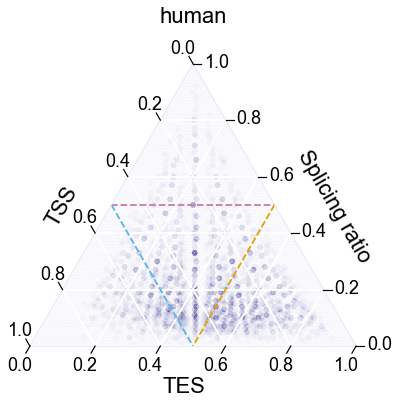

<Figure size 432x288 with 0 Axes>

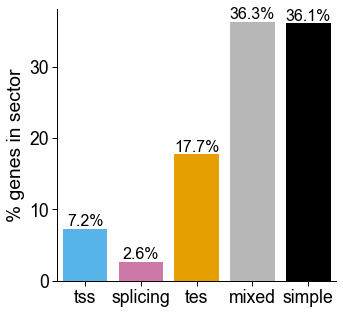

<Figure size 432x288 with 0 Axes>

In [230]:
c_dict, order = get_sector_colors()
species='human'

fname = f'figures/{species}_tissue_specific_simplex.pdf'
subset = {'source': 'specific_isos'}
title = species

temp = ca.plot_simplex(top='splicing_ratio',
        subset=subset,
        density=True,
        density_scale=100,
        density_cmap='Purples',
        log_density=True,
        sectors=True,
        scatter=False,
        legend=False,
        title=title,
        size_scale=0.6,
        density_cbar=False,
        fname=fname)

plt.show()
plt.clf()


temp = temp[['gid', 'sector']].groupby('sector').count().reset_index().rename({'gid': 'n_genes'}, axis=1)
temp['total'] = temp.n_genes.sum()
temp['perc'] = (temp['n_genes']/temp['total'])*100

sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
plt.figure(figsize=(5,5))

ax = sns.barplot(data=temp, y='perc', x='sector',
                 palette=c_dict, order=order,
                 saturation=1)
                 # , height=3, aspect=1.2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('% genes in sector')
ax.set_xlabel('')

def add_perc_2(ax):
    ylim = ax.get_ylim()[1]
    n_cats = len(ax.patches)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        x = p.get_x() + p.get_width() / 2
        y = p.get_y() + p.get_height() + ylim*0.01
        ax.annotate(percentage, (x, y), size=16, horizontalalignment='center')

add_perc_2(ax)
fname = f'figures/{species}_specific_isos_genes_per_sector.pdf'
plt.savefig(fname, dpi=500)
plt.show()
plt.clf()

In [231]:
df.head()

,gid,n_iso,n_tss,n_ic,n_tes,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,source,gid_stable,gname,biotype_category
0,ENSG00000000003,19,1,8,6,2.285714,0.107692,0.646154,0.246154,tes,specific_isos,ENSG00000000003,TSPAN6,protein_coding
1,ENSG00000000005,1,1,1,1,1.000000,0.333333,0.333333,0.333333,simple,specific_isos,ENSG00000000005,TNMD,protein_coding
2,ENSG00000000419,2,2,2,2,1.000000,0.400000,0.400000,0.200000,mixed,specific_isos,ENSG00000000419,DPM1,protein_coding
3,ENSG00000000457,4,3,3,4,0.857143,0.381818,0.509091,0.109091,tes,specific_isos,ENSG00000000457,SCYL3,protein_coding
4,ENSG00000000460,12,3,6,4,1.714286,0.344262,0.459016,0.196721,mixed,specific_isos,ENSG00000000460,C1orf112,protein_coding


In [234]:
df['n_genes'] = len(df.gid.unique().tolist())
df.head()

,gid,n_iso,n_tss,n_ic,n_tes,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,source,gid_stable,gname,biotype_category,n_genes
0,ENSG00000000003,19,1,8,6,2.285714,0.107692,0.646154,0.246154,tes,specific_isos,ENSG00000000003,TSPAN6,protein_coding,24944
1,ENSG00000000005,1,1,1,1,1.000000,0.333333,0.333333,0.333333,simple,specific_isos,ENSG00000000005,TNMD,protein_coding,24944
2,ENSG00000000419,2,2,2,2,1.000000,0.400000,0.400000,0.200000,mixed,specific_isos,ENSG00000000419,DPM1,protein_coding,24944
3,ENSG00000000457,4,3,3,4,0.857143,0.381818,0.509091,0.109091,tes,specific_isos,ENSG00000000457,SCYL3,protein_coding,24944
4,ENSG00000000460,12,3,6,4,1.714286,0.344262,0.459016,0.196721,mixed,specific_isos,ENSG00000000460,C1orf112,protein_coding,24944


In [244]:
temp = df[['gid', 'n_tss', 'n_ic', 'n_tes']].set_index('gid').melt(ignore_index=False).rename({'variable':'feat', 'value':'count'}, axis=1)
temp['feat'] = temp.feat.str.split('n_', expand=True)[1]
temp.reset_index(inplace=True)
temp.head()

,gid,feat,count
0,ENSG00000000003,tss,1
1,ENSG00000000005,tss,1
2,ENSG00000000419,tss,2
3,ENSG00000000457,tss,3
4,ENSG00000000460,tss,3


In [247]:
c_dict, order = get_feat_triplet_colors()
c_dict

{'tss': '#56B4E9', 'ic': '#CC79A7', 'tes': '#E69F00', 'triplet': '#009E73'}

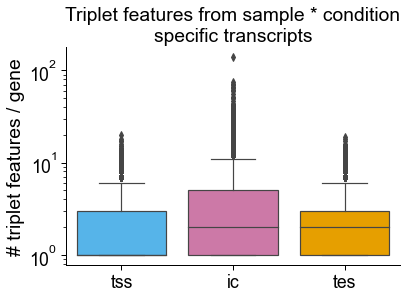

In [263]:
ax = sns.boxplot(temp, y='count', x='feat', palette=c_dict, saturation=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
_ = ax.set(xlabel='', ylabel='# triplet features / gene', title='Triplet features from sample * condition\nspecific transcripts', yscale='log')
plt.savefig('figures/boxplot_triplet_feat_in_sample_specific.png', bbox_inches='tight', dpi=500)

In [262]:
print(f'median # tsss from tissue-specific transcripts: {df.n_tss.median()}')
print(f'median # tess from tissue-specific transcripts: {df.n_tes.median()}')
print(f'median # ics from tissue-specific transcripts: {df.n_ic.median()}')

median # tsss from tissue-specific transcripts: 1.0
median # tess from tissue-specific transcripts: 2.0
median # ics from tissue-specific transcripts: 2.0
